In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from blast.utils.functions import get_nsrdb_temperature_data

Found location:  Honolulu, Honolulu County, Hawaii, 96813, United States
Input coordiantes: 	 (21.304547, -157.855676)
Coordinates of nearest point in NSRDB: 	 [  21.29 -157.86]


Text(0, 0.5, 'Temperature (C)')

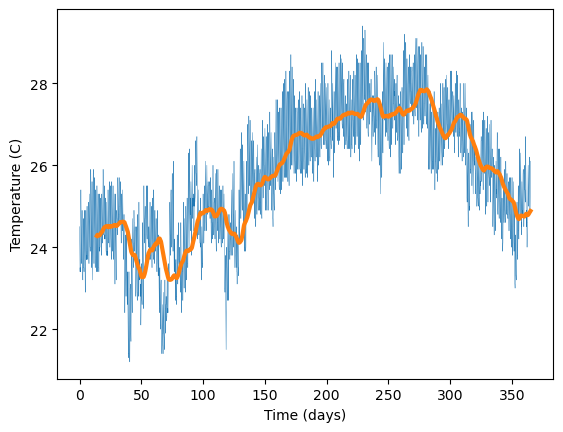

In [2]:
climate = get_nsrdb_temperature_data('Honolulu, Hawaii')
plt.plot(climate['Time_s']/(3600*24), climate['Temperature_C'], linewidth=0.3)
plt.plot(climate['Time_s']/(3600*24), climate['Temperature_C'].rolling(14*24*2).mean(), linewidth=3)
plt.xlabel('Time (days)')
plt.ylabel('Temperature (C)')

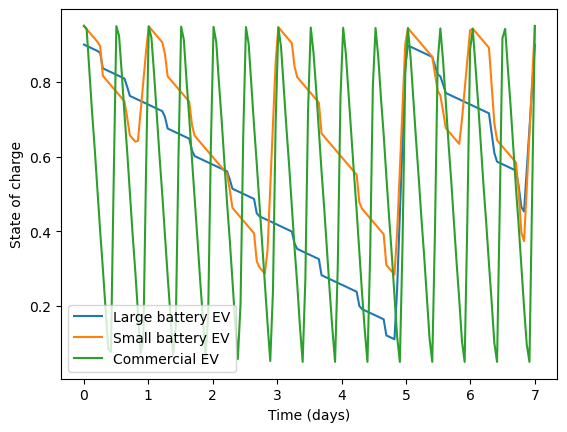

In [8]:
ev_largebattery = pd.read_csv('application profiles/personal_ev_largebatt.csv')
ev_largebattery = ev_largebattery.iloc[np.linspace(0, 24*3600*7 - 1, 24*7)]

ev_smallbattery = pd.read_csv('application profiles/personal_ev_smallbatt.csv')
ev_smallbattery = ev_smallbattery.iloc[np.linspace(0, 24*3600*7 - 1, 24*7)]

commercial_ev = pd.read_csv('application profiles/commercial_ev.csv')
commercial_ev = commercial_ev.iloc[np.linspace(0, 24*3600*7 - 1, 24*7)]

plt.plot(ev_largebattery['Time_s'] / (24*3600), ev_largebattery['SOC'], label='Large battery EV')
plt.plot(ev_smallbattery['Time_s'] / (24*3600), ev_smallbattery['SOC'], label='Small battery EV')
plt.plot(commercial_ev['Time_s'] / (24*3600), commercial_ev['SOC'], label='Commercial EV')
plt.xlabel('Time (days)')
plt.ylabel('State of charge')
plt.legend()

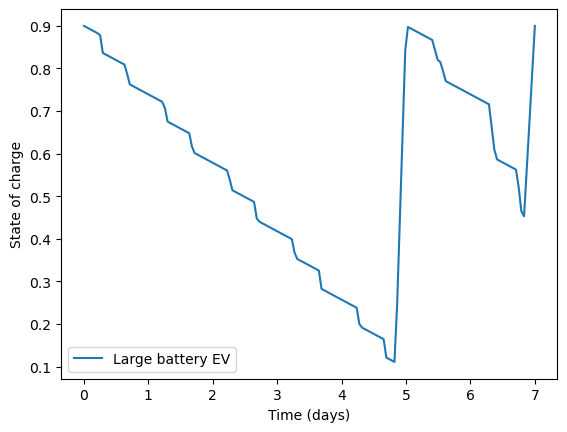

In [9]:
plt.plot(ev_largebattery['Time_s'] / (24*3600), ev_largebattery['SOC'], label='Large battery EV')
plt.xlabel('Time (days)')
plt.ylabel('State of charge')
plt.legend()

In [10]:
from blast.utils.functions import assemble_one_year_input
input_ev_smallbatt = assemble_one_year_input(ev_smallbattery, climate)
input_ev_largebatt = assemble_one_year_input(ev_largebattery, climate)
input_ev_commercial = assemble_one_year_input(commercial_ev, climate)

c:\Users\pgasper\AppData\Local\anaconda3\envs\blast-lite\Lib\site-packages\blast\models\degradation_model.py:465: RuntimeWarning: invalid value encountered in scalar divide
  Crate = np.trapz(abs_instantaneous_crate, t_days[1:]) / delta_t_days
c:\Users\pgasper\AppData\Local\anaconda3\envs\blast-lite\Lib\site-packages\blast\models\nmc111_gr_Kokam75Ah_2017.py:158: RuntimeWarning: invalid value encountered in scalar divide
  q1 = np.trapz(q1, x=t_secs) / delta_t_secs
c:\Users\pgasper\AppData\Local\anaconda3\envs\blast-lite\Lib\site-packages\blast\models\nmc111_gr_Kokam75Ah_2017.py:159: RuntimeWarning: invalid value encountered in scalar divide
  q3 = np.trapz(q3, x=t_secs) / delta_t_secs
c:\Users\pgasper\AppData\Local\anaconda3\envs\blast-lite\Lib\site-packages\blast\models\nmc111_gr_Kokam75Ah_2017.py:160: RuntimeWarning: invalid value encountered in scalar divide
  q5 = np.trapz(q5, x=t_secs) / delta_t_secs
c:\Users\pgasper\AppData\Local\anaconda3\envs\blast-lite\Lib\site-packages\blast\

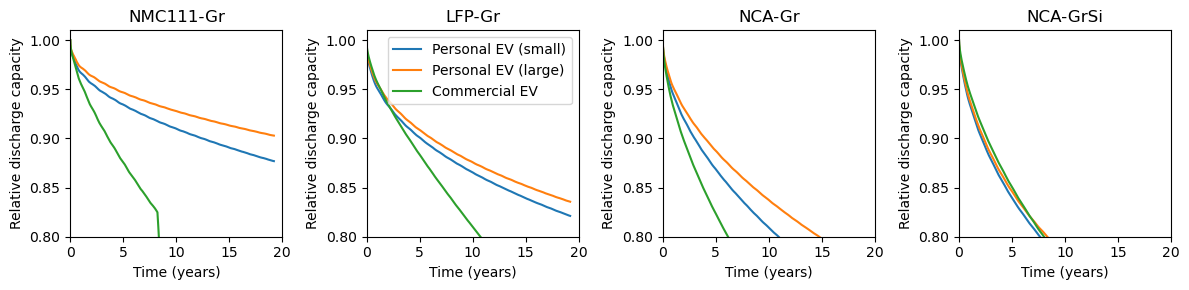

In [11]:
from blast.models.nmc111_gr_Kokam75Ah_2017 import Nmc111_Gr_Kokam75Ah_Battery
from blast.models.lfp_gr_SonyMurata3Ah_2018 import Lfp_Gr_SonyMurata3Ah_Battery
from blast.models.nca_gr_Panasonic3Ah_2018 import Nca_Gr_Panasonic3Ah_Battery
from blast.models.nca_grsi_SonyMurata2p5Ah_2023 import NCA_GrSi_SonyMurata2p5Ah_Battery

batteries = {
    'NMC111-Gr': [Nmc111_Gr_Kokam75Ah_Battery(), Nmc111_Gr_Kokam75Ah_Battery(), Nmc111_Gr_Kokam75Ah_Battery()],
    'LFP-Gr': [Lfp_Gr_SonyMurata3Ah_Battery(), Lfp_Gr_SonyMurata3Ah_Battery(), Lfp_Gr_SonyMurata3Ah_Battery()],
    'NCA-Gr': [Nca_Gr_Panasonic3Ah_Battery(), Nca_Gr_Panasonic3Ah_Battery(), Nca_Gr_Panasonic3Ah_Battery()],
    'NCA-GrSi': [NCA_GrSi_SonyMurata2p5Ah_Battery(), NCA_GrSi_SonyMurata2p5Ah_Battery(), NCA_GrSi_SonyMurata2p5Ah_Battery()]
}
simulations = {
    'Personal EV (small)': input_ev_smallbatt,
    'Personal EV (large)': input_ev_largebatt,
    'Commercial EV': input_ev_commercial,
}

years_simulation = 20
fig, ax = plt.subplots(1, 4, figsize=(12,3))
idx_ax = 0
for batt_type, battery in batteries.items():
    idx_sim = 0
    for sim_type, sim_input in simulations.items():
        batt = battery[idx_sim]
        batt.simulate_battery_life(sim_input, years_simulation)

        ax[idx_ax].plot(batt.stressors['t_days']/365, batt.outputs['q'], label=sim_type)
        idx_sim += 1
        
    ax[idx_ax].set_xlabel('Time (years)')
    ax[idx_ax].set_ylabel('Relative discharge capacity')
    ax[idx_ax].set_ylim((0.8, 1.01))
    ax[idx_ax].set_xlim((0, 20))
    ax[idx_ax].set_title(batt_type)
    if idx_ax == 1:
        ax[idx_ax].legend(loc='upper right')
    idx_ax += 1

plt.tight_layout()

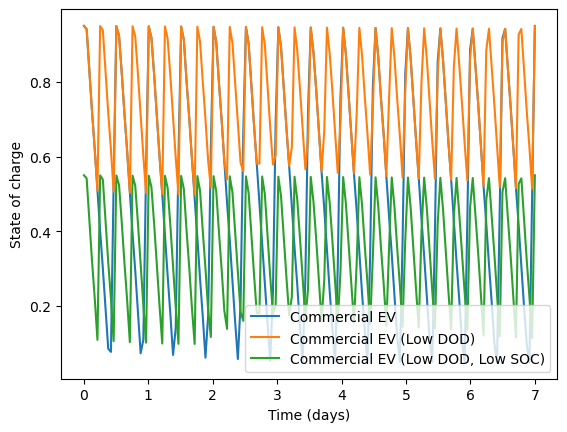

In [12]:
commercial_ev_lowdod = pd.read_csv('application profiles/commercial_ev_lowdod.csv')
commercial_ev_lowdod = commercial_ev_lowdod.iloc[np.linspace(0, 24*3600*7 - 1, 24*7)]

commercial_ev_lowdod_lowsoc = commercial_ev_lowdod.copy()
commercial_ev_lowdod_lowsoc['SOC'] += -0.4

plt.plot(commercial_ev['Time_s'] / (24*3600), commercial_ev['SOC'], label='Commercial EV')
plt.plot(commercial_ev_lowdod['Time_s'] / (24*3600), commercial_ev_lowdod['SOC'], label='Commercial EV (Low DOD)')
plt.plot(commercial_ev_lowdod_lowsoc['Time_s'] / (24*3600), commercial_ev_lowdod_lowsoc['SOC'], label='Commercial EV (Low DOD, Low SOC)')
plt.xlabel('Time (days)')
plt.ylabel('State of charge')
plt.legend()

c:\Users\pgasper\AppData\Local\anaconda3\envs\blast-lite\Lib\site-packages\blast\models\degradation_model.py:465: RuntimeWarning: invalid value encountered in scalar divide
  Crate = np.trapz(abs_instantaneous_crate, t_days[1:]) / delta_t_days
c:\Users\pgasper\AppData\Local\anaconda3\envs\blast-lite\Lib\site-packages\blast\models\nmc111_gr_Kokam75Ah_2017.py:158: RuntimeWarning: invalid value encountered in scalar divide
  q1 = np.trapz(q1, x=t_secs) / delta_t_secs
c:\Users\pgasper\AppData\Local\anaconda3\envs\blast-lite\Lib\site-packages\blast\models\nmc111_gr_Kokam75Ah_2017.py:159: RuntimeWarning: invalid value encountered in scalar divide
  q3 = np.trapz(q3, x=t_secs) / delta_t_secs
c:\Users\pgasper\AppData\Local\anaconda3\envs\blast-lite\Lib\site-packages\blast\models\nmc111_gr_Kokam75Ah_2017.py:160: RuntimeWarning: invalid value encountered in scalar divide
  q5 = np.trapz(q5, x=t_secs) / delta_t_secs
c:\Users\pgasper\AppData\Local\anaconda3\envs\blast-lite\Lib\site-packages\blast\

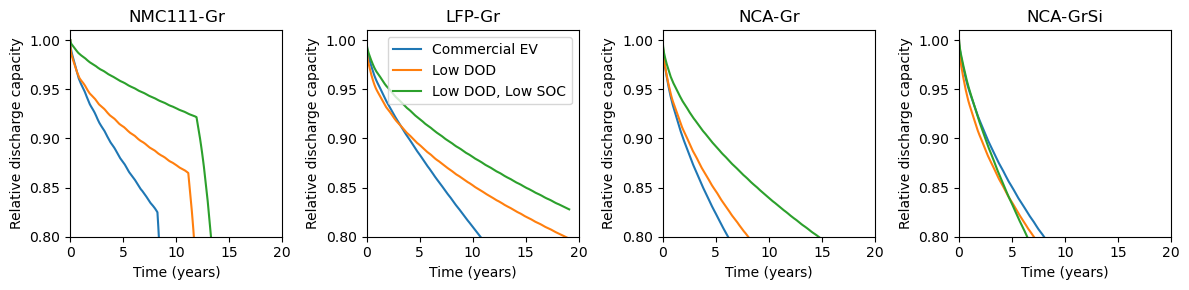

In [13]:
input_ev_commercial_lowdod = assemble_one_year_input(commercial_ev_lowdod, climate)
input_ev_commercial_lowdod_lowsoc = assemble_one_year_input(commercial_ev_lowdod_lowsoc, climate)

batteries = {
    'NMC111-Gr': [Nmc111_Gr_Kokam75Ah_Battery(), Nmc111_Gr_Kokam75Ah_Battery(), Nmc111_Gr_Kokam75Ah_Battery()],
    'LFP-Gr': [Lfp_Gr_SonyMurata3Ah_Battery(), Lfp_Gr_SonyMurata3Ah_Battery(), Lfp_Gr_SonyMurata3Ah_Battery()],
    'NCA-Gr': [Nca_Gr_Panasonic3Ah_Battery(), Nca_Gr_Panasonic3Ah_Battery(), Nca_Gr_Panasonic3Ah_Battery()],
    'NCA-GrSi': [NCA_GrSi_SonyMurata2p5Ah_Battery(), NCA_GrSi_SonyMurata2p5Ah_Battery(), NCA_GrSi_SonyMurata2p5Ah_Battery()]
}
simulations = {
    'Commercial EV': input_ev_commercial,
    'Low DOD': input_ev_commercial_lowdod,
    'Low DOD, Low SOC': input_ev_commercial_lowdod_lowsoc,
}

years_simulation = 20
fig, ax = plt.subplots(1, 4, figsize=(12,3))
idx_ax = 0
for batt_type, battery in batteries.items():
    idx_sim = 0
    for sim_type, sim_input in simulations.items():
        batt = battery[idx_sim]
        batt.simulate_battery_life(sim_input, years_simulation)

        ax[idx_ax].plot(batt.stressors['t_days']/365, batt.outputs['q'], label=sim_type)
        idx_sim += 1
        
    ax[idx_ax].set_xlabel('Time (years)')
    ax[idx_ax].set_ylabel('Relative discharge capacity')
    ax[idx_ax].set_ylim((0.8, 1.01))
    ax[idx_ax].set_xlim((0, 20))
    ax[idx_ax].set_title(batt_type)
    if idx_ax == 1:
        ax[idx_ax].legend(loc='upper right')
    idx_ax += 1

plt.tight_layout()